# Optimality Gap of LLM-based Agents in Gridworld Problem  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/XO-Appleton/RL-LLM-Optimality-Research/blob/main/notebooks/optimality_gap_LLM.ipynb)

- Author: Yumo Bai
- Date: Nov 3, 2023
- Email: baiym104@gmail.com

## Introduction

In this blog post, we delve into the fascinating world of Reinforcement Learning (RL) by exploring a Taxi Gridworld problem. Our journey involves the use of advanced techniques like Large Language Models (LLM) and the Langchain library, showcasing how these tools can be leveraged to solve complex RL challenges.

## Objectives

1. Understanding the Gridworld: We first familiarize ourselves with the Gridworld environment, its rules, and dynamics.
2. GPT Chat Completion: Utilizing LLM, particularly GPT-4, we explore how language models can aid in decision-making processes.
3. Langchain ReAct Agent: We integrate Langchain, a tool for combining LLMs with decision-making processes, to build an agent with enhanced problem solving capabilities.

## Understanding the Gridworld

The Taxi Gridworld is a classic problem in RL. In the Taxi environment, the world is represented as a grid, where each cell can be occupied by the taxi, a passenger, a destination, or be empty. The taxi's objective is straightforward: to pick up a passenger from a designated location and drop them off at their desired destination. The challenge lies in efficiently planning routes, avoiding obstacles, and making strategic decisions under constraints.

<figure style="text-align: center; display: table; margin: 0 auto;">
    <img src="https://gymnasium.farama.org/_images/taxi.gif" alt="A Random Walk of the Taxi environment" style="width: auto; display: block; margin: 0 auto;">
    <figcaption style="display: block; text-align: center;">the Taxi environment</figcaption>
</figure>

Learn more about the Taxi environment at [the Gymnasium Taxi documentation.](https://gymnasium.farama.org/environments/toy_text/taxi/)

### Installing Packages

In [ ]:
!pip install gym
!apt-get install python3-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

### Import Packages

In [ ]:
import gym
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib
from IPython.display import HTML, Video, clear_output
import numpy as np

matplotlib.rcParams['animation.embed_limit'] = 50

### Building the Environment

In [ ]:
SIMP_ENV_NAME = 'Taxi-v3'
RENDER_MODE = 'rgb_array'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Action Space Discrete(6)
State Space Discrete(500)


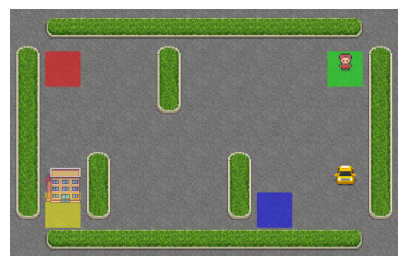

In [ ]:
env = gym.make(SIMP_ENV_NAME, new_step_api=True, render_mode=RENDER_MODE)
env.reset(seed=42)
init_frame = env.render()[0]

fig, ax = plt.subplots(figsize=(4, 2.5))
ax.axis('off')
plt.imshow(init_frame)

# Show the number of actions and possible states in the environment
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

As we can see from the initial rendering of the environment. The taxi is currently sitting on the 4th row and last reachable cell (4, 5). The passenger is waiting on the (G)reen cell and the Destination is represented by the building on the (Y)ellow cell.

There are six actions in the Action Space:

- 0: Move south (down)

- 1: Move north (up)

- 2: Move east (right)

- 3: Move west (left)

- 4: Pickup passenger

- 5: Drop off passenger

To help us get an intuition of how the objects interact with each other, let's visualize it with a simple random walk episode.

### Random Action Episode

In [ ]:
frames = [init_frame]  # List to hold the frames
history = []

done = False
truncated = False
while not done and not truncated:
    action = env.action_space.sample()  # Take a random action
    state, reward, done, truncated, info = env.step(action)
    frame = env.render()
    frames.append(frame[0])  # Save the frame
    history.append((state, reward, done, truncated, info))

env.close()  # Don't forget to close the environment

In [ ]:
# Helper function to generate a mp4 animation of the episode.
def update(frame):
    plt.imshow(frame)
    plt.axis('off')

fig, ax = plt.subplots(figsize=(4, 2.5))
ax.axis('off')  # Hide the axis

# Generate the animation
ani = FuncAnimation(fig, update, frames=frames, blit=False, repeat=False)
ani.save('random_walk_episode.gif', writer='imagemagick', fps=4)

# Close the figure window
plt.close()

<figure style="text-align: center; display: table; margin: 0 auto;">
    <img src="https://github.com/XO-Appleton/RL-LLM-Optimality-Research/blob/main/outputs/random_walk_episode.gif?raw=true" alt="A Random Walk of the Taxi environment" style="width: auto; display: block; margin: 0 auto;">
    <figcaption style="display: block; text-align: center;">Random Walk Episode</figcaption>
</figure>

We see that the taxi can pick up and drop off the passenger on one of the colored grids. The taxi can run into walls or pickup/dropoff passenger outside of colored grids but that does not change the state of environment. Let's now improve our RL agent by optimizing with a classic yet powerful RL algorithm called Q-learning.

### Optimize with Q-Learning

Q-learning is a type of Reinforcement Learning (RL) algorithm. In RL, you have an agent (in our case, the taxi) that learns how to make decisions (like where to move) by interacting with an environment (the grid world). The goal is for the agent to learn the best actions to take in different situations to achieve its objective, which is usually defined by a reward system and can be quantified by what we call Q-Value.

#### Key Points in Simple Terms

- The taxi tries different things and learns from what happens.
- It uses a special lookup table (Q-table) to keep track of how good each action is in each situation.
- The taxi updates this table based on its experiences.
- Over time, the taxi gets better at knowing the best actions to take.
- Eventually, the taxi learns the most efficient routes and actions to complete its task.

Example of Q-Table:

<img src="https://upload.wikimedia.org/wikipedia/commons/e/e0/Q-Learning_Matrix_Initialized_and_After_Training.png" width="450" height="450" alt="Example Q-Table">

#### Behaviour Exploration (Training)

We first initialize a Q-Table and train it as described above. In my case I trained it for 100000 episodes and took nearly 5 hours.

In [ ]:
q_table = np.zeros([env.observation_space.n, env.action_space.n])

Training finished.



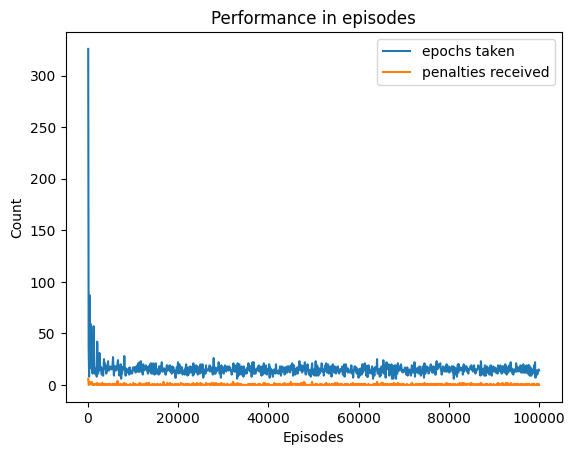

CPU times: user 4h 46min 40s, sys: 31.2 s, total: 4h 47min 11s
Wall time: 4h 49min 18s


In [ ]:
%%time
"""Training the agent"""

import random

def q_learning(env, q_table, num_episodes=100000, alpha=0.1, gamma=0.6, epsilon=0.1):

  # For plotting metrics
  episodes = []
  all_epochs = []
  all_penalties = []

  for i in range(1, num_episodes+1):
    state = env.reset()
    epochs, penalties, reward, = 0, 0, 0
    done = False

    while not done:
      if random.uniform(0, 1) < epsilon:
          action = env.action_space.sample() # Explore action space
      else:
          action = np.argmax(q_table[state]) # Exploit learned values
      next_state, reward, done, truncated, info = env.step(action)

      old_value = q_table[state, action]
      next_max = np.max(q_table[next_state])

      new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
      q_table[state, action] = new_value

      if reward == -10:
          penalties += 1 # Executing “pickup” and “drop-off” actions illegally.

      state = next_state
      epochs += 1

    if i % 100 == 0:
        print(f"Episode: {i}")
        clear_output(wait=True)
        episodes.append(i)
        all_epochs.append(epochs)
        all_penalties.append(penalties)

  print("Training finished.\n")

  return episodes, all_epochs, all_penalties

episodes, all_epochs, all_penalties = q_learning(env, q_table)

plt.figure()
plt.plot(episodes, all_epochs, label='epochs taken')
plt.plot(episodes, all_penalties, label='penalties received')
plt.title('Performance in episodes')
plt.xlabel('Episodes')
plt.ylabel('Count')
plt.legend()
plt.show()

np.save('q_table.npy', q_table)

from google.colab import files
files.download('q_table.npy')

In the first couple of episodes, our agent took around 350 steps to complete the objectve. The number quickly dropped down to around 20-ish. The penalties and steps taken flunctuates but never diminishes as we set 10% of the steps to be random (ϵ = 10).

Let's see how the agent performs in the exploit stage.

##### Q-Learning Performance

In [ ]:
# Load the trained Q-Table

q_table = np.load('../src/q_table.npy')

q_table

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ -2.41837064,  -2.3639511 ,  -2.41837064,  -2.3639511 ,
         -2.27325184, -11.36394725],
       [ -1.870144  ,  -1.45024008,  -1.870144  ,  -1.45024001,
         -0.7504    , -10.45023435],
       ...,
       [ -1.00897079,   0.41599966,  -0.98354117,  -1.09891256,
         -4.07163433,  -4.63241735],
       [ -2.16706467,  -2.12207113,  -2.17063126,  -2.12206944,
         -4.41436947,  -6.76108838],
       [  3.0152869 ,   0.84399347,   3.09857041,  11.        ,
         -2.54830551,  -2.93639053]])

In [ ]:
total_steps, total_penalties, total_reward = 0, 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    steps, penalties, reward = 0, 0, 0

    done, truncated = False, False

    while not done and not truncated:
        action = np.argmax(q_table[state])  # Take the best action
        next_state, reward, done, truncated, info = env.step(action)
        total_reward += reward

        if reward == -10:
            penalties += 1

        state = next_state
        steps += 1

    total_penalties += penalties
    total_steps += steps

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_steps / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")
print(f"Average reward per episode: {total_reward / episodes}")

Results after 100 episodes:
Average timesteps per episode: 13.27
Average penalties per episode: 0.0
Average reward per episode: 7.73


Our agent takes 12.7 steps on average to complete the objective and makes zero illegal pickup/dropoff actions. Impressive!

Let's see it in action with an animation. We will also record the steps taken and rewards received to compare with the other agents later.

In [ ]:
PERFORMANCE = {}

state = env.reset(seed=42)
init_frame = env.render()[0]
frames = [init_frame]  # List to hold the frames
total_reward = 0

done = False
truncated = False

while not done and not truncated:
    action = np.argmax(q_table[state])  # Take the best action
    state, reward, done, truncated, info = env.step(action)
    frame = env.render()
    frames.append(frame[0])  # Save the frame
    total_reward += reward

env.close()  # Don't forget to close the environment

PERFORMANCE['optimal_episode'] = (len(frames)-1, total_reward, done) # (steps_taken, rewards_received_from_episode, object_achieved)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.axis('off')

ani = FuncAnimation(fig, update, frames=frames, blit=False, repeat=False)
ani.save('optimal_episode.gif', writer='imagemagick', fps=2)

# Close the figure window
plt.close()

<figure style="text-align: center; display: table; margin: 0 auto;">
    <img src="https://github.com/XO-Appleton/RL-LLM-Optimality-Research/blob/main/outputs/optimal_episode.gif?raw=true" alt="Optimal Episode" style="width: auto; display: block; margin: 0 auto;">
    <figcaption style="display: block; text-align: center;">Optimal Episode</figcaption>
</figure>

The RL agent completes a clean episode with one the most efficient ways.

Now let's get into the fun part and see how would our groundbreaking GPT models perform on the driver seat here.

## GPT Chat Completion

In this section we will ask the GPT models to analyze the textual description of the environment and come up with a solution. We will compare different prompting method as well as textual encodings of the positions.

Let's import the packages.

In [ ]:
!pip install scipy
!pip install tenacity
!pip install tiktoken
!pip install termcolor
!pip install openai
!pip install requests
!pip install langchain

In [ ]:
import json
import openai
import requests
from tenacity import retry, wait_random_exponential, stop_after_attempt
from termcolor import colored
import os

# Replace with your own OpenAI API key
os.environ['OPENAI_API_KEY'] = 'YOUR_KEY_HERE'

gpt_3 = "gpt-3.5-turbo-0613"
gpt_4 = "gpt-4-1106-preview"

In [ ]:
# Connect to OpenAI API
@retry(wait=wait_random_exponential(multiplier=1, max=40), stop=stop_after_attempt(3))
def chat_completion_request(messages, tools=None, tool_choice=None, model=gpt_3):
    headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer " + os.environ['OPENAI_API_KEY'],
    }
    json_data = {"model": model, "messages": messages}
    if tools is not None:
        json_data.update({"tools": tools})
    if tool_choice is not None:
        json_data.update({"tool_choice": tool_choice})
    try:
        response = requests.post(
            "https://api.openai.com/v1/chat/completions",
            headers=headers,
            json=json_data,
        )
        return response
    except Exception as e:
        print("Unable to generate ChatCompletion response")
        print(f"Exception: {e}")
        return e

To help GPT understand the problem. We will need to introduce some basic descriptions of the problem that we're dealing with.

In [ ]:
problem_desc = """You will be controlling a taxi to pick up a passenger and drop him off at the destination location in a gridworld constructed as follows:
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Objective: Plan the taxi's movements ahead and carefully to avoid the walls. Pickup the passenger and drop him off at the destination.
Look ahead for walls that could potentially run into. Plan the route carefully to avoid them. Only make the action after you have a good confidence about the route you have planned.

 The task is going to be performed in a gridworld with specifications as follows:
- The gridworld is constructed with the following symbols: ["|", "-", ":", " ", "R", "G", "Y", "B"]:
  --`|` and `-` represent a wall that the taxi cannot pass through, East-West or North-South, respectively.
  -- `:` represent a boundary that a taxi can pass through.
  -- `R, G, Y, B` represents colored regions that a passenger can be on, the passenger will start on one of them and the destination will be one of them as well.
  -- ` ` represent space that the taxi can park at, the taxi can also go onto the colored regions.
- There are six actions in the action space ["South","North","East","West", "Pickup", 'Dropoff'], first four moves the taxi for one unit to the corresponding directions (down, up, right, left), last two picks up and drops off the passenger.
  -- The passenger can only be picked up or dropped off at one of the colored regions.
  -- The taxi's position will be represented as (row, col). `row` and `col` are 1-indexed.
  -- Attempting moving the taxi onto or jumping over a wall would not change its position.
  -- "Pickup" and "Dropoff" should only be performed when taxi's position equals to the desired position
- You can only choose one of the six actions listed above.
"""

### Vague Description
We will start simple with a prompt that is vague about the positions like we would to ask a human to perform the task.

In [ ]:
vague_prompt = """The taxi starts at the cell to the north-east of B grid. The passenger is at G, the destination is at Y. Show the sequence of actions that would achieve the objective.
When you have an final answer, use the format:

Final Answer: [Actions Taken]"""

def get_answer(problem_desc, prompt, model):
    messages = []
    messages.append({"role": "system", "content": problem_desc})
    messages.append({"role": "user", "content": prompt})
    chat_response = chat_completion_request(
        messages, model=model
    )
    assistant_message = chat_response.json()["choices"][0]["message"]
    messages.append(assistant_message)

    return assistant_message['content']

In [ ]:
response = get_answer(problem_desc, vague_prompt, gpt_3)
print(response)

To solve this task, we can follow the following sequence of actions:

1. Move South to reach row 4, col 1 (the start point of B grid).
2. Move West to reach row 4, col 8 (the end point of B grid).
3. Move North to reach row 1, col 8 (the end point of Y grid).
4. Move East to reach row 1, col 7 (the destination G grid).
5. Perform Dropoff at row 1, col 7 (the destination G grid).
6. Move West to reach row 1, col 4 (the start point of G grid).
7. Move South to reach row 4, col 4 (the start point of B grid).
8. Perform Pickup at row 4, col 4.
9. Move West to reach row 4, col 1 (the start point of B grid).
10. Move North to reach row 1, col 1.
11. Perform Dropoff at row 1, col 1 (the destination Y grid).

Final Answer: [South, West, North, East, Dropoff, West, South, Pickup, West, North, Dropoff]


Our GPT-3.5 model seem to have no idea about the spacial relationship between different objects in the GridWorld. It also seem to be confused about which direction the taxi would be moved to.

Let's define a function to help us visualize how does the answer play out.

In [ ]:
ACTION_MAP =  {'South':0, 'North':1, 'East':2, 'West':3, 'Pickup':4, 'Dropoff':5}

def response_to_actions(response, output_filename="episode.gif"):
    actions = response.split('Final Answer:')[-1].strip(' []').split(', ')
    actions = [a.strip('"\'') for a in actions]

    figure, ax = plt.subplots(figsize=(4, 2.5))
    ax.axis('off')  # Hide the axis

    env = gym.make(SIMP_ENV_NAME, new_step_api=True, render_mode='rgb_array')
    env.reset(seed=42)
    init_frame = env.render()[0]
    frames = [init_frame]  # List to hold the frames

    total_reward = 0 # Calculate total reward to compare performance.

    for action in actions:
        state, reward, done, truncated, info = env.step(ACTION_MAP[action])
        frame = env.render()
        frames.append(frame[0])  # Save the frame
        plt.imshow(frame[0])

        total_reward += reward

    PERFORMANCE[output_filename[:-4]] = (len(frames)-1, total_reward, done)
    env.close()  # Don't forget to close the environment

    ani = FuncAnimation(figure, update, frames=frames, blit=False, repeat=False)
    ani.save(output_filename, writer='Pillow', fps=2)

    # Close the figure window
    plt.close()

In [ ]:
# Call the function with the response
response_to_actions(response, output_filename='gpt_3_vague.gif')

<figure style="text-align: center; display: table; margin: 0 auto;">
    <img src="https://github.com/XO-Appleton/RL-LLM-Optimality-Research/blob/main/outputs/gpt_3_vague.gif?raw=true" alt="Optimal Episode" style="width: auto; display: block; margin: 0 auto;">
    <figcaption style="display: block; text-align: center;">GPT-3.5 with vague prompt</figcaption>
</figure>

Let's see how the newly released GPT-4 turbo model would do.

In [ ]:
response = get_answer(problem_desc, vague_prompt, gpt_4)
print(response)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


To pick up the passenger at G and drop them off at Y, the taxi should execute the following series of actions:

1. Move South to go down.
2. Move South again to the square directly above G.
3. Move East to enter G, where the passenger is located.
4. Perform the Pickup action to pick up the passenger.
5. Move West to exit the G grid.
6. Move North twice to move to the square directly to the right of R.
7. Move West to go through the colon.
8. Move West again to enter the R grid.
9. Move South to go through the colon and move to the square directly above Y.
10. Move South to enter Y.
11. Perform the Dropoff action to drop off the passenger.

Combining these actions gives us the following sequence:

Final Answer: [South, South, East, Pickup, West, North, North, West, West, South, South, Dropoff]


In [ ]:
response_to_actions(response, 'gpt_4_vague.gif')

<figure style="text-align: center; display: table; margin: 0 auto;">
    <img src="https://github.com/XO-Appleton/RL-LLM-Optimality-Research/blob/main/outputs/gpt_4_vague.gif?raw=true" alt="GPT-4 with vague prompt" style="width: auto; display: block; margin: 0 auto;">
    <figcaption style="display: block; text-align: center;">GPT-4 with vague prompt</figcaption>
</figure>

I ran the prompt for a couple of times during the development stage. In most of the cases, the GPT-4 model is able to provide a somewhat reasonable plan before giving the final answer, but it is still not able to capture the location information from our textual description.

Very interestingly, the GPT-4 model occationaly tries to encode the location of the taxi to form (row, col) from the raw text in the prompt before trying to make plan. It ususally achieves a much better result in those cases.

We probably should incorporate the location encoding as part of our prompt for consistent performance.

### Location Encoding

An easy way to encode location information is to simply expressing it as tuple of (row, col) given the simple structure of our gridworld. For simplicity, we will treat each cell as a column and let GPT try to figure out the position of the walls.

In [ ]:
location_encoding = """The location of the taxi, passenger, and destination will be represented as tuples (row, col).
The row and col are 1-indexed. The wall `|` between (row, col) and (row, col+1) prevents taxi from travelling from (row, col) to (row, col+1) and vice versa.
The Actions `South`, `North`, `East`, `West` changes the location of the taxi to (row+1, col), (row-1, col), (row, col+1), (row, col-1), respectively. `Pickup` and `Dropoff` does not change the location of the taxi.
The taxi starts at the (4, 5). The passenger is at (1, 5), the destination is at (5, 1).
"""

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
basic_prompt = """
Show the sequence of actions that would achieve the objective. i.e location_passenger == location_destination

When you have an final answer, you MUST use this format:
Final Answer: [Actions Taken]"""

location_encoded_prompt = location_encoding + basic_prompt

In [ ]:
response = get_answer(problem_desc, location_encoded_prompt, gpt_3)
print(response)
response_to_actions(response, 'gpt_3_location_encoded.gif')

To pick up the passenger and drop him off at the destination, the following actions can be taken:

1. Move North (from (4, 5) to (3, 5))
2. Move West (from (3, 5) to (3, 4))
3. Move North (from (3, 4) to (2, 4))
4. Move West (from (2, 4) to (2, 3))
5. Move North (from (2, 3) to (1, 3))
6. Pickup passenger (at (1, 3))
7. Move South (from (1, 3) to (2, 3))
8. Move East (from (2, 3) to (2, 4))
9. Move North (from (2, 4) to (1, 4))
10. Move West (from (1, 4) to (1, 3))
11. Move North (from (1, 3) to (5, 1))
12. Drop off passenger (at (5, 1))

Final Answer: [North, West, North, West, North, Pickup, South, East, North, West, North, Dropoff]


<figure style="text-align: center; display: table; margin: 0 auto;">
    <img src="https://github.com/XO-Appleton/RL-LLM-Optimality-Research/blob/main/outputs/gpt_3_location_encoded.gif?raw=true" alt="GPT-4 with vague prompt" style="width: auto; display: block; margin: 0 auto;">
    <figcaption style="display: block; text-align: center;">GPT-3 with a location encoded prompt</figcaption>
</figure>

Despite having the exact location encodings, Our GPT-3 model is hallucinating severely. Let's check how does GPT-4 perform.

In [ ]:
response = get_answer(problem_desc, location_encoded_prompt, gpt_4)
print(response)
response_to_actions(response, 'gpt_4_location_encoded.gif')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


First, we need to plan the route from the taxi's starting position to the passenger's location while avoiding walls. Then we need to pick up the passenger and plan the route from the passenger's location to the destination. Let's begin.

Starting position of the taxi is (4, 5).

1. Move the taxi North (up) to (3, 5): Action "North"
2. Move the taxi North (up) to (2, 5): Action "North"
3. Move the taxi North (up) to (1, 5): Action "North"
4. Perform the "Pickup" action at the passenger's location.
5. Now the passenger is inside the taxi, we should move South (down) to (2, 5): Action "South"
6. Move South (down) to (3, 5): Action "South"
7. Move South (down) to (4, 5): Action "South"
8. Move South (down) to (5, 5): Action "South"
9. Move West (left) to (5, 4): Action "West"
10. Move West (left) to (5, 3): Action "West"
11. Move West (left) to (5, 2): Action "West"
12. Perform the "Dropoff" action at the destination.

Final Answer: ["North", "North", "North", "Pickup", "South", "South", "

<figure style="text-align: center; display: table; margin: 0 auto;">
    <img src="https://github.com/XO-Appleton/RL-LLM-Optimality-Research/blob/main/outputs/gpt_4_location_encoded.gif?raw=true" alt="GPT-4 with vague prompt" style="width: auto; display: block; margin: 0 auto;">
    <figcaption style="display: block; text-align: center;">GPT-4 with a location encoded prompt</figcaption>
</figure>

Compared to wasting time getting to the B grid first, the GPT-4 model finds a straight forward approach to complete the objective with the location encodings. However, it neglects the walls when planning its route and gets stuck at (5, 4).

### CoT and ToT prompting

Another common ways of improving the performance of the LLM models is by using special promptings like CoT and ToT.

Chain of Thought (CoT) is a technique used in problem-solving. CoT involves the AI model writing out its reasoning in a step-by-step manner before arriving at the final answer. This method helps the AI to tackle complex problems more effectively and also makes its reasoning process transparent and easier to understand for humans.

For example, if you ask an AI to solve a math word problem, instead of just giving the final number, it would first explain each step of how it got there, like identifying key information, doing calculations step by step, and then combining these to reach the final answer.

![Chain of Thought](https://www.promptingguide.ai/_next/image?url=%2F_next%2Fstatic%2Fmedia%2Fcot.1933d9fe.png&w=1920&q=75)

In our case, we will use what we call Zero-Shot CoT, which is done simply by adding this magical sentense `Let's think step by step.` where it fits.

In [ ]:
cot = """
Show the sequence of actions that would achieve the objective. i.e location_passenger == location_destination

When you have an final answer, you MUST use this format:
Final Answer: [Actions Taken]

Let's think step by step.

Begin!
"""

cot_prompt = location_encoding + cot

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
response = get_answer(problem_desc, cot_prompt, gpt_3)
print(response)
response_to_actions(response, 'gpt_3_cot_location_encoded.gif')

Final Answer: ['South', 'South', 'South', 'South', 'South', 'West', 'West', 'West', 'West', 'Pickup', 'North', 'North', 'North', 'North', 'West', 'West', 'South', 'South', 'South', 'South', 'East', 'East', 'East', 'East', 'South', 'South', 'South', 'South', 'South', 'South', 'West', 'West', 'West', 'West', 'West', 'Pickup', 'North', 'North', 'North', 'North', 'West', 'West', 'West', 'West', 'Dropoff']


In [ ]:
response = get_answer(problem_desc, cot_prompt, gpt_4)
print(response)
response_to_actions(response, 'gpt_4_cot_location_encoded.gif')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


First, as a taxi, we need to navigate to the passenger's location at (1, 5). We will begin at (4, 5) and follow the path. Here is a step-by-step breakdown which avoids the walls:

- The taxi starts at (4, 5)
- Move North to (3, 5)
- Move North to (2, 5)
- Move North to (1, 5)
- Perform a Pickup
- Move South to (2, 5)
- Move South to (3, 5)
- Move West to (3, 4)
- Move South to (4, 4)
- Move South to (5, 4)
- Move West to (5, 3)
- Move North to (4, 3)
- Move West to (4, 2)
- Move West to (4, 1)
- Move North to (3, 1)
- Move North to (2, 1)
- Move North to (1, 1)
- Move North to (1, 1)
- Move East to (1, 2)
- Move East to (1, 3)
- Move South to (2, 3)
- Move South to (3, 3)
- Move South to (4, 3)
- Move South to (5, 3)
- Move West to (5, 2)
- Move West to (5, 1)
- Perform a Dropoff

Now, let's summarize these steps into the final answer format with the actions that are taken:

Final Answer: [North, North, North, Pickup, South, South, West, South, South, West, North, West, West, North, No

<table>
    <tr>
        <td>
            <figure>
                <img src="https://github.com/XO-Appleton/RL-LLM-Optimality-Research/blob/main/outputs/gpt_3_cot_location_encoded.gif?raw=true" alt="GPT-3 with CoT prompt (location encoded)" style="width: 100%;">
                <figcaption style="text-align: center;">GPT-3 with CoT prompt (location encoded)</figcaption>
            </figure>
        </td>
        <td>
            <figure>
                <img src="https://github.com/XO-Appleton/RL-LLM-Optimality-Research/blob/main/outputs/gpt_4_cot_location_encoded.gif?raw=true" alt="GPT-4 with CoT prompt (location encoded)" style="width: 100%;">
                <figcaption style="text-align: center;">GPT-4 with CoT prompt (location encoded)</figcaption>
            </figure>
        </td>
    </tr>
</table>


Seems that with the CoT prompting method, the main issues with GPT-3 and GPT-4 persist to be hallucination and neglecting the wall position, respectively.

Hallucination is tricky to solve and might have to do with the model's foundamental performance. But we might be able to help our GPT-4 model by modifying our encoding method to include the wall positions. Before we modify it, let's check how the models perform with ToT.

Tree of Thoughts (ToT) is a framework that generalizes over chain-of-thought prompting and encourages exploration over thoughts that serve as intermediate steps for general problem solving with language models.

![Tree of Thoughts](https://www.promptingguide.ai/_next/image?url=%2F_next%2Fstatic%2Fmedia%2FTOT.3b13bc5e.png&w=3840&q=75)

In [ ]:
tot = """
Imagine five different experts are working on this task.
All experts will write down 1 step of their thinking, then share it with the group.
Then all experts will go on to the next step, etc.
If any expert realises they're wrong at any point then they leave.

When the experts have found the sequence of actions that achieves the objective, i.e location_passenger == location_destination, you MUST use this format:
Final Answer: [The list of action steps taken.]

Begin!
"""

tot_prompt = location_encoding + tot

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
response = get_answer(problem_desc, tot_prompt, gpt_3)
print(response)
response_to_actions(response, 'gpt_3_tot_location_encoded.gif')

Expert 1: My initial thought is to move the taxi to the passenger's location. So the first step is to move North to (3, 5).

Expert 2: I agree with Expert 1's first step. Next, let's move East to (3, 6) to get closer to the passenger.

Expert 3: I see that we need to pick up the passenger at (1, 5), so the next step should be 'Pickup'.

Expert 4: After picking up the passenger, we need to move to the destination at (5, 1). To do that, let's move East to (3, 7).

Expert 5: I think we should move South to (4, 7) to avoid the wall.

Expert 1: Great suggestion. Now, let's move East to (4, 8) and then move South to (5, 8) to get closer to the destination.

Expert 2: I agree. To reach the destination at (5, 1), we need to move West to (5, 7).

Expert 3: After that, we need to move South to (6, 7) to avoid the wall.

Expert 4: Now, let's move West to (6, 6) to come closer to the destination.

Expert 1: Finally, we can move South to (7, 6) and then move West to (7, 5) to reach the destination.

In [ ]:
response = get_answer(problem_desc, tot_prompt, gpt_4)
print(response)
response_to_actions(response, 'gpt_4_tot_location_encoded.gif')

Step 1:
- Expert 1: We start at (4, 5) and need to pick up the passenger at (1, 5). We should go north as our first move to approach the passenger.
- Expert 2: Given that walls block movement east and west directly above and below the taxi's start position, I agree that the first move should be north.
- Expert 3: I concur with Expert 1 and Expert 2 that the first optimal move is to head north to avoid the walls and make our way towards the passenger.
- Expert 4: Starting at (4, 5), heading north makes sense because it's the only option to move towards the passenger without being blocked by walls.
- Expert 5: The taxi needs to head towards the passenger located at (1, 5), so moving north is necessary; there are no other legal moves to start with.

Step 2:
- Expert 1: The taxi has reached (3, 5) after the first move. The next action should be moving north again to go closer to the passenger.
- Expert 2: I'm realizing that my initial thoughts didn't account for the wall between rows 3 and

<table>
    <tr>
        <td>
            <figure>
                <img src="https://github.com/XO-Appleton/RL-LLM-Optimality-Research/blob/main/outputs/gpt_3_tot_location_encoded.gif?raw=true" alt="GPT-3 with CoT prompt (location encoded)" style="width: 100%;">
                <figcaption style="text-align: center;">GPT-3 with ToT prompt (location encoded)</figcaption>
            </figure>
        </td>
        <td>
            <figure>
                <img src="https://github.com/XO-Appleton/RL-LLM-Optimality-Research/blob/main/outputs/gpt_4_tot_location_encoded.gif?raw=true" alt="GPT-4 with CoT prompt (location encoded)" style="width: 100%;">
                <figcaption style="text-align: center;">GPT-4 with ToT prompt (location encoded)</figcaption>
            </figure>
        </td>
    </tr>
</table>


The ToT prompting did not change much about GPT-3, it suprisingly made the GPT-4 model hallucinate a lot more severely. Different `Experts` seemed to come to the same incorrect answers at steps. Some of them would realize the mistake and resign from the group whereas the others proceed and builds up from their initial errors. I suspect by introducing more experts the capability of logical reasoning of GPT-4 is divided, resulting worse performing individual sub-agents.

### Wall-Inclusive Location Encoding

To allow LLM to access the wall locations, we would need to find a way to represent their locations. To make it consistent with our current way of encoding, we need to expand our gridworld so every `|` take up a column as well.

In [ ]:
wall_inclusive_location_encoding = """
- The location of the taxi, passenger, and destination will be represented as tuples (row, col).
- The positions of walls `|` are encoded in as location (row, col). The taxi cannot move onto or jump over the wall.
  -- i.e The taxi cannot go from (5, 7) to (5, 5) given there is a wall at (5, 6)
  -- The walls are located at [(1, 0), (1, 4), (1, 10), (2, 0), (2, 4), (2, 10), (3, 0), (3, 10), (4, 0), (4, 2), (4, 6), (4, 10), (5, 0), (5, 2), (5, 6), (5, 10)].
- The row and col are 0-indexed. The taxi cannot move onto or jump over the wall.
  -- "South","North" changes the taxi's position to (row+1, col), (row-1, col).
  -- If there is not a wall at (row, col+/-1), "East", "West" moves the taxi to (row, col+/-2), else the taxi stays at the same position.
 -- "Pickup" and "Dropoff" does not change the location of the taxi.

The taxi starts at the (4, 9). The passenger is at (1, 9), the destination is at (5, 1).
"""

wall_inclusive_location_encoded_prompt = wall_inclusive_location_encoding + basic_prompt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
response = get_answer(problem_desc, wall_inclusive_location_encoded_prompt, gpt_4)
print(response)
response_to_actions(response, 'gpt_4_inclusive_location_encoded.gif')

To solve this task, the taxi needs to maneuver its way to the passenger at (1, 9), pick them up, and then travel to the destination at (5, 1) to drop them off. Let's plan the taxi's movements in accordance with the gridworld's rules:

1. The taxi starts at (4, 9).
2. Move west (left) to avoid the wall and get in line with the passenger: one move west.
3. Move north (up) three times to reach the passenger's row, avoiding the wall: three moves north.
4. Once aligned with the passenger's row, move east (right) to the passenger's location: two moves east.
5. Pickup the passenger.
6. Move south (down) to the bottom row, avoiding the wall: four moves south.
7. Finally, move west (left) to reach the destination drop-off zone: seven moves west.
8. Dropoff the passenger.

Note: Some actions might seem not to follow the shortest path due to the necessity of avoiding walls.

Here's the detailed action sequence:

Final Answer: ["West", "North", "North", "North", "East", "East", "Pickup", "South", 

<figure style="text-align: center; display: table; margin: 0 auto;">
    <img src="https://github.com/XO-Appleton/RL-LLM-Optimality-Research/blob/main/outputs/gpt_4_inclusive_location_encoded.gif?raw=true" alt="GPT-4 with vague prompt" style="width: auto; display: block; margin: 0 auto;">
    <figcaption style="display: block; text-align: center;">GPT-4 with a location encoded prompt (wall inclusive)</figcaption>
</figure>

Our model is still having trouble understanding the spacial relationship of the walls and the taxi when making decisions. It seems quite challenging for the chat model to complete the task as it is only making a plan from the starting position and cannot account for any issue it run into during the execution.

Let's bless it with LangChain and turn it into an agent that can use Tools and make observations of the environment.

## Langchain ReAct Agent

Now we're actually asking our GPT-4 model to be the agent controlling the taxi rather than only trying to analyze the problem from a textual approach.


### **What is ReAct?**

ReAct, short for "Reasoning-Acting", which is a method used to enable LLMs to interact with external tools or systems in a more structured and effective way. Here's a simple explanation:

Reasoning (Re): This is where the language model thinks about a problem or task. It uses its vast knowledge and understanding of language to come up with ideas, strategies, or solutions. For example, if the task is to navigate a maze, the model would reason about the best path to take.

Acting (Act): After reasoning, the model takes action based on its thoughts. This action could be interacting with an external tool or system. For example, in the maze navigation task, the action would be the model instructing which direction to move in the maze.

![ReAct Logic](https://react-lm.github.io/files/diagram.png)

### **What is an Agent?**

The core idea of agents is to use a language model to choose a sequence of actions to take. The language model is used as a reasoning engine to determine which actions to take and in which order.

In LangChain, we can construct a AgentExecutor with the following structure:

`LLM Chain (LLM - Prompt)` | `Tools` | `Output Parser`

Here are what they mean:
- **Prompt Template**: A set of instructions that guides how the LLM processes inputs and generates outputs. The brain that drives the taxi. [\(docs\)](https://python.langchain.com/en/latest/modules/prompts/prompt_templates.html).
- **LLM Chain**: A Chain brings together a prompt template with an LLM that will execute it - in this case we use gpt-4-turbo but it can work with other large language models too. [\(docs\)](https://python.langchain.com/docs/modules/chains.html).
- **Tools**: An external service (python function) that the LLM can use to perform tasks [\(docs\)](https://python.langchain.com/en/latest/modules/agents/tools.html).
- **Output Parser**: Parses the response from executing the LLM Chain. We can enable complex interactions and interations by extracting intermediate results in their response and passed into the next step of the chain [\(docs\)](https://python.langchain.com/en/latest/modules/prompts/prompt_templates.html).

The AgentExecutor interact with the Environment with Tools specified, make Observations and pass it to the next iteration.

### **Workflow Overview**:

![ReAcT Agent Workflow](https://github.com/XO-Appleton/RL-LLM-Optimality-Research/blob/main/utils/ReAct.drawio.png?raw=true)

1. Initialization: The agent is initialized with a specific LLM, prompt template, tools, and output parser.
2. Interaction Loop:
- The environment provides an initial state or task description.
- The agent, using the LLM and ReAct Logic, generates a response that includes reasoning and a proposed action.
- The output parser interprets this response and converts it into actionable steps.
- The Agent Executor applies these actions to the environment.
- The environment updates its state based on these actions and provides new information to the agent.
- This loop continues until the task is completed or a stopping condition is met.

### Import Packages

In [ ]:
from tqdm.auto import tqdm
from typing import List, Union
import zipfile

# Langchain imports
from langchain.agents import Tool, AgentExecutor, LLMSingleActionAgent, AgentOutputParser
from langchain.prompts import BaseChatPromptTemplate, ChatPromptTemplate
from langchain import SerpAPIWrapper, LLMChain
from langchain.schema import AgentAction, AgentFinish, HumanMessage, SystemMessage
# LLM wrapper
from langchain.chat_models import ChatOpenAI
from langchain import OpenAI
# Conversational memory
from langchain.memory import ConversationBufferWindowMemory
# Embeddings and vectorstore
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.schema.output_parser import StrOutputParser

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Taxi World ANSI rendering

To generate observations for the LLM, we can use the ANSI rendering of the environment to get a textual representation.

Let's first get a sense of how the textual representation should be interpreted with an optimal episode walk.

In [ ]:
from time import sleep

env = gym.make('Taxi-v3', new_step_api=True, render_mode='ansi')
state = env.reset(seed=42)
init_frame = env.render()[0]
frames = [init_frame]  # List to hold the frames
total_reward = 0

done = False
truncated = False

while not done and not truncated:
    action = np.argmax(q_table[state])  # Take the best action
    state, reward, done, truncated, info = env.step(action)
    frame = env.render()
    frames.append(frame[0])  # Save the frame
    total_reward += reward

env.close()

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame)
        print(f"Timestep: {i + 1}")
        sleep(.5)

print_frames(frames)

![Optimal Episode Rendered as ANSI](https://github.com/XO-Appleton/RL-LLM-Optimality-Research/blob/main/outputs/textual_rendering.gif?raw=true)

We can see that an empty taxi is represented by an yellow background, while it is green when it has the passenger on it. The location of the passenger is represented by painting the grid letter blue. And the destination is represented by the purple letter before the passenger is dropped off on it.

### Defining the Tool

With these knowledge in mind, we can write some helper functions that would help interpret the textual rendering into texts that could be easier understand by the LLM.

In [ ]:
# helper functions for the tools

import re

# ANSI escape sequences for colors
COLORS = {
    '\x1b[34;1m': 'blue',
    '\x1b[35m': 'purple',
    '\x1b[43m': 'yellow',
    '\x1b[42m': 'green',
    '\x1b[0m': 'reset'
}

def get_walls(plain_text):
    """extracts the locations of walls from the plain text representation of the taxi world"""
    walls = []
    plain_lines = plain_text.strip().split('\n')

    for row_index, line in enumerate(plain_lines[:-1]):
        for i, char in enumerate(line.strip('|')):
            if char == '|':
                walls.append((row_index, i+1))
    return walls


# Function to parse the ANSI-rendered text
def parse_ansi_rendered_text(rendered_text):
    # Split the rendered text into lines
    lines = rendered_text.strip().split('\n')

    # Initialize variables
    last_action = lines[-1].strip('( )') if lines[-1].strip('( )') in ACTION_MAP else None
    taxi_row, taxi_col = None, None
    passenger_location = None
    destination = None
    passenger_in_taxi = False

    # Iterate over the lines to find the taxi, passenger, and destination
    for row_index, line in enumerate(lines[:-1]):
        # Split the line into cells based on the grid separators
        cells = re.split(r'\||:', line)
        for col_index, cell in enumerate(cells):
            if '\x1b[42m' in cell:  # Check for green background indicating the passenger is in the taxi
                passenger_in_taxi = True
                taxi_row, taxi_col = row_index, col_index*2-1
            elif '\x1b[43m' in cell:  # Check for yellow background indicating the taxi
                taxi_row, taxi_col = row_index, col_index*2-1
            if '\x1b[34;1m' in cell:  # Check for blue text indicating the passenger
                passenger_location = row_index, col_index*2-1
                # passenger_location = re.sub(r'\x1b\[\d+(;\d+)?m', '', cell).strip()
            if '\x1b[35m' in cell:  # Check for purple text indicating the destination
                destination = row_index, col_index*2-1
                # destination = re.sub(r'\x1b\[\d+(;\d+)?m', '', cell).strip()

    # Remove the ANSI escape sequences for colors
    plain_text = re.sub(r'\x1b\[\d+(;\d+)?m', '', rendered_text)
    walls = get_walls(plain_text)

    return {
        'last_action' : last_action,
        'taxi_location': (taxi_row, taxi_col),
        'passenger_location': passenger_location,
        'destination': destination,
        'passenger_in_taxi': passenger_in_taxi,
        'wall_locations': walls
    }

# Function to generate a textual description from the parsed information
def generate_textual_description(parsed_info):
    description = ""
    if parsed_info['last_action']:
        description += f"Last action taken is {parsed_info['last_action']}. "
    description += f"The taxi is currently at {parsed_info['taxi_location']}. "
    if parsed_info['passenger_in_taxi']:
        description += "The passenger is in the taxi. "
    else:
        description += f"The passenger is waiting at {parsed_info['passenger_location']}. "
    if parsed_info['passenger_location'] == parsed_info['destination']:
        description += f"The passenger has successfully reached the destination at {parsed_info['passenger_location']}. "
    else:
        description += f"The destination is at {parsed_info['destination']}.\n"

    if parsed_info['wall_locations']:
        description += f'There are walls at {parsed_info["wall_locations"]}. \n'

    return description

# Example usage
parsed_info = parse_ansi_rendered_text(init_frame)
textual_description = generate_textual_description(parsed_info)

print(parsed_info)
print(textual_description)

{'last_action': None, 'taxi_location': (4, 9), 'passenger_location': (1, 9), 'destination': (5, 1), 'passenger_in_taxi': False, 'wall_locations': [(1, 4), (2, 4), (4, 2), (4, 6), (5, 2), (5, 6)]}
The taxi is currently at (4, 9). The passenger is waiting at (1, 9). The destination is at (5, 1).
There are walls at [(1, 4), (2, 4), (4, 2), (4, 6), (5, 2), (5, 6)]. 



The interpretation looks reasonable. Now let's define the tool for the LLM to use to make the action and receive the updated environment status.

We will call it `take_action_step`.

In [ ]:
def take_action_step(action):
    '''Make one action step in the environment. Action can be one of South, North, East, West, Pickup, Dropoff'''
    action = ACTION_MAP[action.strip('\n')]
    env.step(action)

    rendered_text = env.render()[0]
    print('\n'+rendered_text)
    parsed_info = parse_ansi_rendered_text(rendered_text)
    textual_description = generate_textual_description(parsed_info)

    return textual_description

In [ ]:
# Define a list of tools
from langchain.tools import StructuredTool

# wrap the function into a Tool
tool = StructuredTool.from_function(take_action_step)

#### Customizing the ReAct Prompt and OutputParser

In [ ]:
# Set up the prompt with input variables for tools, user input and a scratchpad for the model to record its workings
react = """

TOOLS:
------
You have access to the following tools:

{tools}

To use a tool, please use the following format:

```
Thought: Do I need to use a tool? Yes
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
```
... (this Thought/Action/Action Input/Observation can repeat N times)

When you have a response to say to the Human, or if you do not need to use a tool, you MUST use the format:

```
Thought: The objective has been achieved. i.e `passenger_location` == `destination_location`
Final Answer: [The list of action steps taken.]
```

Begin!

Task: {input}
{agent_scratchpad}"""

react_template = problem_desc + wall_inclusive_location_encoding + react

In [ ]:
# Set up a prompt template
class ReActPromptTemplate(BaseChatPromptTemplate):
    # The template to use
    template: str
    # The list of tools available
    tools: List[Tool]

    def format_messages(self, **kwargs) -> str:
        # Get the intermediate steps (AgentAction, Observation tuples)

        # Format them in a particular way
        intermediate_steps = kwargs.pop("intermediate_steps")
        thoughts = ""
        for action, observation in intermediate_steps:
            thoughts += action.log
            thoughts += f"\nObservation: {observation}\nThought: "

        # Set the agent_scratchpad variable to that value
        kwargs["agent_scratchpad"] = thoughts

        # Create a tools variable from the list of tools provided
        kwargs["tools"] = "\n".join([f"{tool.name}: {tool.description}" for tool in self.tools])

        # Create a list of tool names for the tools provided
        kwargs["tool_names"] = ", ".join([tool.name for tool in self.tools])
        formatted = self.template.format(**kwargs)
        return [HumanMessage(content=formatted)]

react_prompt = ReActPromptTemplate(
    template=react_template,
    tools=[tool],
    # This omits the `agent_scratchpad`, `tools`, and `tool_names` variables because those are generated dynamically
    # This includes the `intermediate_steps` variable because that is needed
    input_variables=["input", "intermediate_steps"]
)

In [ ]:
class ReActOutputParser(AgentOutputParser):

    def parse(self, llm_output: str) -> Union[AgentAction, AgentFinish]:

        # Check if agent should finish
        if "Final Answer:" in llm_output:
            return AgentFinish(
                # Return values is generally always a dictionary with a single `output` key
                # It is not recommended to try anything else at the moment :)
                return_values={"output": llm_output.split("Final Answer:")[-1]},
                log=llm_output,
            )

        # Parse out the action and action input
        regex = r"Action: (.*?)[\n]*Action Input:[\s]*(.*)"
        match = re.search(regex, llm_output, re.DOTALL)

        # If it can't parse the output it raises an error
        # You can add your own logic here to handle errors in a different way i.e. pass to a human, give a canned response
        if not match:
            raise ValueError(f"Could not parse LLM output: `{llm_output}`")
        action = match.group(1).strip()
        action_input = match.group(2)

        # Return the action and action input
        return AgentAction(tool=action, tool_input=action_input.strip(" ").strip('"\''), log=llm_output)

react_output_parser = ReActOutputParser()

Now that we have all the components ready, let's put them together and initialize our AgentExecutor.

In [ ]:
# Initiate our GPT instance
llm = ChatOpenAI(model=gpt_4, temperature=0, api_key=os.environ['OPENAI_API_KEY'])

# LLM chain consisting of the LLM and a prompt
llm_chain = LLMChain(llm=llm, prompt=react_prompt)

# Using tools, the LLM chain and output_parser to make an agent
tool_names = [tool.name]

agent = LLMSingleActionAgent(
    llm_chain=llm_chain,
    output_parser=react_output_parser,
    # We use "Observation" as our stop sequence so it will stop when it receives Tool output
    # If you change your prompt template you'll need to adjust this as well
    stop=["\nObservation:"],
    allowed_tools=tool_names
)

# Initiate the agent that will respond to our queries
# Set verbose=True to share the CoT reasoning the LLM goes through
agent_executor = AgentExecutor.from_agent_and_tools(agent=agent, tools=[tool], verbose=True,
                              max_execution_time=120, max_iterations=30)

print('max_iterations: ', agent_executor.max_iterations)
print('max_execution_time: ', agent_executor.max_execution_time)

max_iterations:  30
max_execution_time:  120.0


### ReAct Agent in Action

In [ ]:
# Sandbox env for the agent to interact with
env = gym.make('Taxi-v3', new_step_api=True, render_mode='ansi')
state = env.reset(seed=42)
rendered_text = env.render()[0]

parsed_info = parse_ansi_rendered_text(rendered_text)
textual_description = generate_textual_description(parsed_info)

response = agent_executor.run(textual_description)

env.close()



> Entering new AgentExecutor chain...
Thought: I need to plan the route to pick up the passenger at (1, 9) and then drop them off at the destination (5, 1). The taxi is currently at (4, 9). I need to avoid the walls and make sure to only perform "Pickup" and "Dropoff" when at the correct locations.

Action: take_action_step
Action Input: North
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)



Observation:Last action taken is North. The taxi is currently at (3, 9). The passenger is waiting at (1, 9). The destination is at (5, 1).
There are walls at [(1, 4), (2, 4), (4, 2), (4, 6), (5, 2), (5, 6)]. 

I need to continue moving North to reach the passenger's location.

Action: take_action_step
Action Input: North
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)



Observation:Last action taken is North. The taxi is currently at (2, 9). The passenger is waiting at (1, 9). The destination is at (5, 

In [ ]:
response_to_actions(response, 'gpt_4_ReAcT_Agent.gif')

<figure style="text-align: center; display: table; margin: 0 auto;">
    <img src="https://github.com/XO-Appleton/RL-LLM-Optimality-Research/blob/main/outputs/gpt_4_ReAcT_Agent.gif?raw=true" alt="GPT-4 with vague prompt" style="width: auto; display: block; margin: 0 auto;">
    <figcaption style="display: block; text-align: center;">GPT-4 ReAct Agent</figcaption>
</figure>

The ReAct Agent showed a lot more insight how LLM thinks when observing the environment. Our GPT-4-turbo model seemed shortsighted and had trouble understand how to plan routes, it only looks around 1-2 cells to check for walls but dismisses walls it is 'obviously' going to run into based on its plan. I.e LLM decides to go south then west, then only checks if there is anything blocking the taxi from going south at the position it is making the decision.

Despite shortsighted on planning the walls, the ReAct Agent is able to reflect on being stuck and look for other ways to complete the task. It is our first successful LLM-as-policy approach that achieved the objective.

## Performance Comparison

Now let's compare the effectiveness of these different methods to the optimal policy and summarize what we've found.

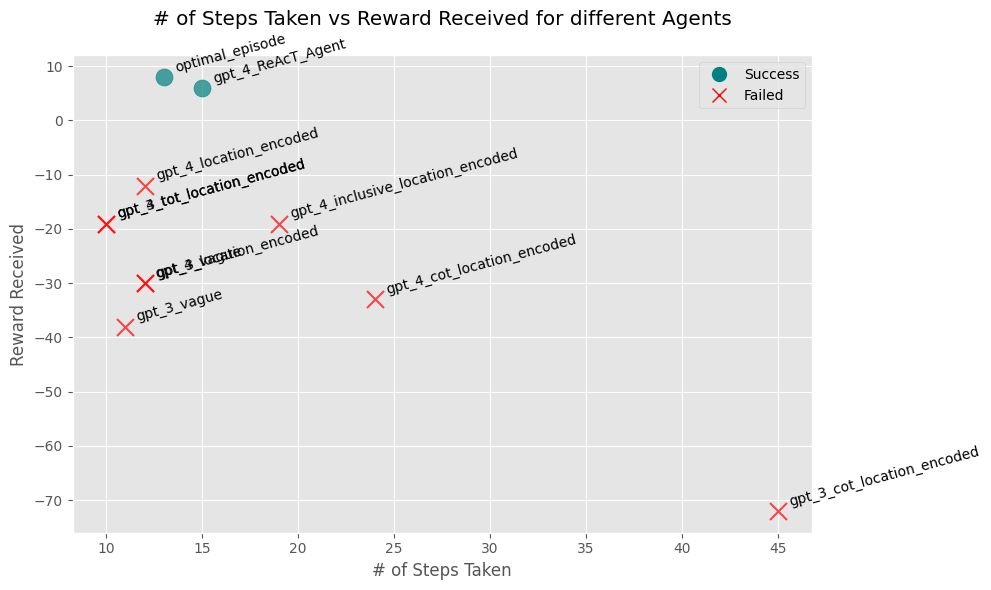

In [ ]:
import matplotlib.lines as mlines

plt.style.use('ggplot')
plt.figure(figsize=(10,6))

for label, (steps_taken, reward, done) in PERFORMANCE.items():
    color = 'teal' if done else 'red'
    marker = 'o' if done else 'x'
    plt.scatter(steps_taken, reward, marker=marker, color=color, label=label, s=150, alpha=0.7)
    plt.annotate(label, (steps_taken+0.5, reward+1), rotation=15)

# Creating custom legend handles
success_handle = mlines.Line2D([], [], color='teal', marker='o', linestyle='None', markersize=10, label='Success')
failed_handle = mlines.Line2D([], [], color='red', marker='x', linestyle='None', markersize=10, label='Failed')

# Adding the custom legend to the plot
plt.legend(handles=[success_handle, failed_handle])
plt.xlabel('# of Steps Taken')
plt.ylabel('Reward Received')
plt.title('# of Steps Taken vs Reward Received for different Agents\n')

# Adding gridlines
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjusting layout
plt.tight_layout()

# Show the plot
plt.show()

**Observations**:
- Out of 10 different LLM-As-Policy agents that we tried, only the ReAct Agent was able to success.
- Most of the unsuccessful agents took 10 to 20 action steps and received -10 to -40 rewards.
- The GPT 3 model with location encodings and CoT prompting took 45 steps and received -70 in a single episode.
- Using the same encoding prompting method, GPT 4 model seemed to perform better on their GPT 3 turbo counter part.

**Location Encoding**:

The steps taken and rewards can indicate the performance to some degree. But it is affected by the randomness of the internal states of the LLM. As we have seen through the process, the LLMs struggled to understand the spacial relationships and retreiving location information for most of the time. GPT 4 was occationally able to spontaneously perform location encoding without given instruction and improve its performance.

The LLM also had major issue understanding the position of the walls without encoding their locations. I've also tried other method such as encoding the wall as (row, (cell_1, cell_2)) but it only made the performance worse as LLM became confused about the location encodings in general.

**Prompt Engineering**:

Applying Zero-shot CoT did not really improve the performance of a LLM chat model, it could be due to our problem description or nature of the task already encourages the LLM to take a CoT approach. ToT on the other hand rather hurt the performance of the LLMs which might be due to the inferior performance of individual `Expert`.

**LLM as Agent**:

Different from the simple one-pass GPT chat completions, building an LLM Agent significantly boosts its performance and enables iterative analysis and freedom of controlling the making action directly. In a Agent pipeline, the LLM is able to make analysis when the observation is different from what it expected and attempts to make new plans. However, it does have significantly higher inference cost (\$0.5 per episode with Agent Execution compared to a single pass costing around \$0.03/episode. Similar proportion in terms of runtime).

## Final Thoughts

Despite demonstrating progress in task comprehension and much stronger ability of problem solving comparing to their precedents, LLMs are still far from taking on complex tasks in the real world. Even the current SOTA like GPT-4-Turbo  has trouble keeping rules in a simple environment like not to jump over a wall depite specified in the prompt.

It is evident that the performance of the LLM heavily rely on the presence of a well-engineered encoding algorithm to help LLM preceive the environment and retreive the crucial informations. But the cost of developing such an algorithm could scale drastically with the complexity of the task. We can imagine that the states of a sufficiently intricate environment might not be able to be converted into a textual representation that is accurate, consistent, and complete.

That being said, the current LLMs are designed to imitate how human write texts instead of focus on problem solving and math. It is intriguing how much progress we are going to see in the next couple of years with LLMs finetuned on  and logical reasoning.

## Reference

Wei, J. (2022, January 28). Chain-of-Thought prompting elicits reasoning in large language models. arXiv.org. https://arxiv.org/abs/2201.11903

Yao, S. (2023, May 17). Tree of Thoughts: Deliberate Problem Solving with Large Language Models. arXiv.org. https://arxiv.org/abs/2305.10601

Yao, S. (2022, October 6). REACT: Synergizing reasoning and acting in language models. arXiv.org. https://arxiv.org/abs/2210.03629

Carta, T. (2023, February 6). Grounding Large Language Models in Interactive Environments with Online Reinforcement Learning. arXiv.org. https://arxiv.org/abs/2302.02662

Michael Ahn, Anthony Brohan, Noah Brown, Yevgen Chebotar, Omar Cortes, Byron David, Chelsea
Finn, Keerthana Gopalakrishnan, Karol Hausman, Alexander Herzog, Daniel Ho, Jasmine Hsu,
Julian Ibarz, Brian Ichter, Alex Irpan, Eric Jang, Rosario Jauregui Ruano, Kyle Jeffrey, Sally
Jesmonth, Nikhil Jayant Joshi, Ryan C. Julian, Dmitry Kalashnikov, Yuheng Kuang, KuangHuei Lee, Sergey Levine, Yao Lu, Linda Luu, Carolina Parada, Peter Pastor, Jornell Quiambao,
Kanishka Rao, Jarek Rettinghouse, Diego M Reyes, Pierre Sermanet, Nicolas Sievers, Clayton Tan,
Alexander Toshev, Vincent Vanhoucke, Fei Xia, Ted Xiao, Peng Xu, Sichun Xu, and Mengyuan
Yan. Do as i can, not as i say: Grounding language in robotic affordances. ArXiv, abs/2204.01691,
2022.

Greg Brockman and Vicki Cheung and Ludwig Pettersson and Jonas Schneider and John Schulman and Jie Tang and Wojciech Zaremba (2016) OpenAI Gym. ArXiv, abs/1606.01540

Van Heeswijk, W., PhD. (2022, January 6). Walking off the cliff with Off-Policy Reinforcement learning. Medium. https://medium.com/towards-data-science/walking-off-the-cliff-with-off-policy-reinforcement-learning-7fdbcdfe31ff

openai-cookbook/examples/How_to_call_functions_with_chat_models.ipynb at main · openai/openai-cookbook. (n.d.). GitHub. https://github.com/openai/openai-cookbook/blob/main/examples/How_to_call_functions_with_chat_models.ipynb

openai-cookbook/examples/How_to_build_a_tool-using_agent_with_Langchain.ipynb at main · openai/openai-cookbook. (n.d.). GitHub. https://github.com/openai/openai-cookbook/blob/main/examples/How_to_build_a_tool-using_agent_with_Langchain.ipynb

Reinforcement Q-Learning from Scratch in Python with OpenAI Gym. (n.d.). https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/

Chain-of-Thought prompting – Nextra. (n.d.). https://www.promptingguide.ai/techniques/cot

Gymnasium documentation. (n.d.). https://gymnasium.farama.org/environments/toy_text/taxi/